In [1]:
# --- Config (change paths if your data lives elsewhere) ---
import json
import os

import matplotlib.pyplot as plt
import pandas as pd

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

base_path = "joint_info_2025.csv"
anom_path = "joint_info_2025_with_anomalies.csv"
labels_path = "labels.jsonl"

# --- Load data and labels ---

base = pd.read_csv(base_path, parse_dates=["date"])
anom = pd.read_csv(anom_path, parse_dates=["date"])

labels = []
with open(labels_path, encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            labels.append(json.loads(line))

print("Base rows:", len(base), " Anom rows:", len(anom))
print("Labels:", len(labels))
print("Base date range:", base["date"].min().date(), "→", base["date"].max().date())
print("Anom date range:", anom["date"].min().date(), "→", anom["date"].max().date())

Base rows: 2644300  Anom rows: 2659942
Labels: 3
Base date range: 2025-01-01 → 2025-12-31
Anom date range: 2025-01-01 → 2025-12-31


Injected anomaly events (from data/labels.jsonl):


,event_id,anomaly_type,start,end,n_accounts,services,driver
0,cost_spike_task_oct__1001,cost_spike,2025-10-15,2025-10-17,30,all,Increase driven by unusually high token usage ...
1,volume_spike_tasks_mar__1002,volume_spike,2025-03-05,2025-03-07,45,all,Increase driven by unusually high number of ta...
2,cap_spike_jun__1003,cap_spike,2025-06-20,2025-06-22,15,concurrency,Increase driven by unusually high concurrent c...



Rows in anomaly dataset marked as anomaly-affected: 16,431


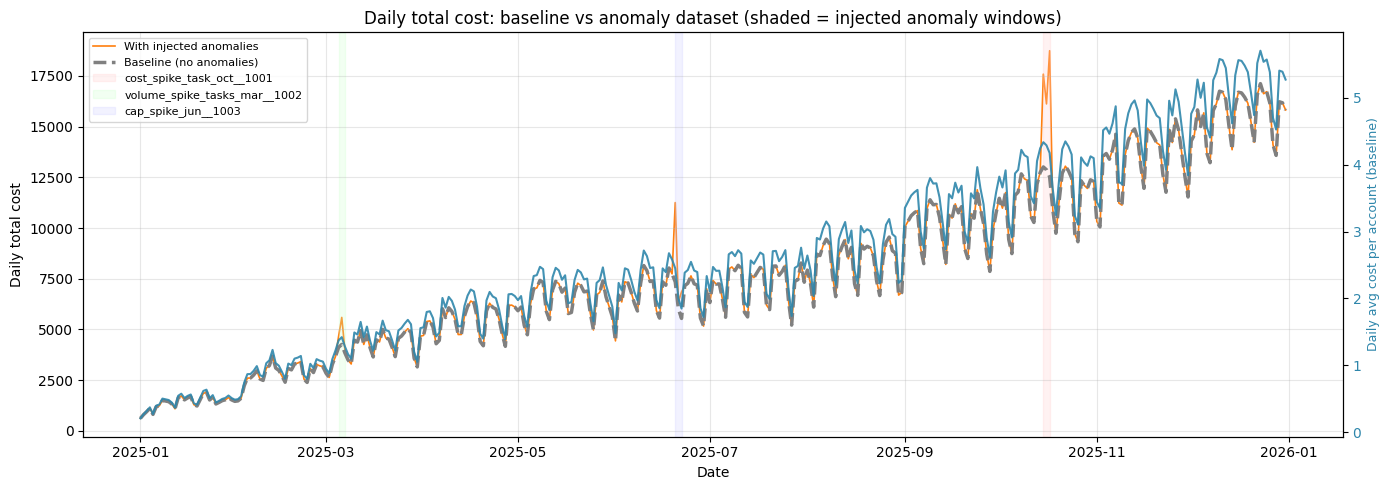

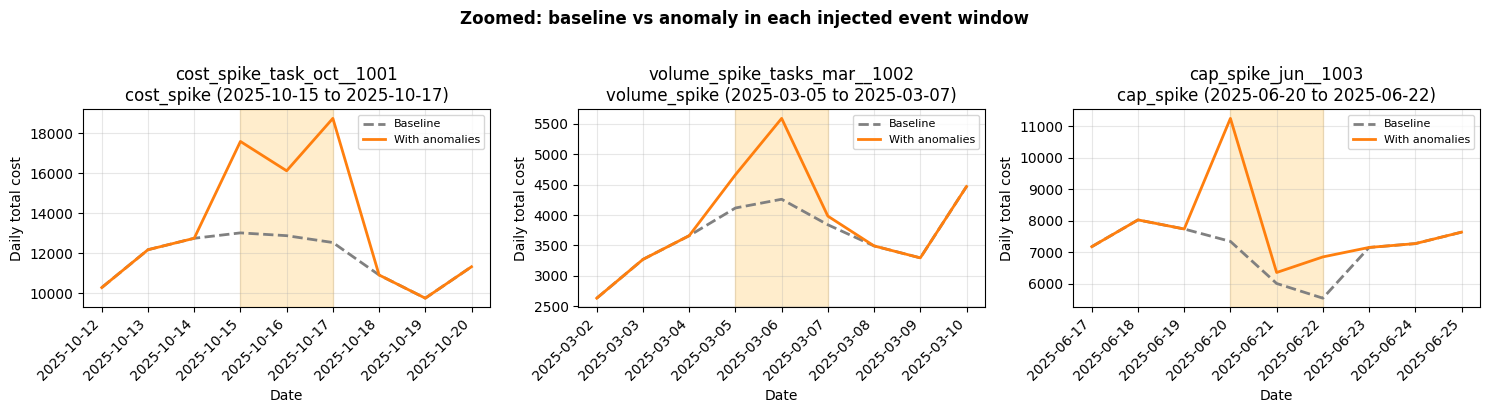

In [2]:
# ============================================================================
# INJECTED ANOMALIES (from labels.jsonl) — make them visible
# ============================================================================

#
# Summary table of injected events
summary = []
for L in labels:
    summary.append(
        {
            "event_id": L["event_id"],
            "anomaly_type": L["anomaly_type"],
            "start": L["start_date"],
            "end": L["end_date"],
            "n_accounts": L["n_accounts"],
            "services": ", ".join(L["affected_services"]),
            "driver": L.get("driver_template", "")[:60]
            + ("..." if len(L.get("driver_template", "")) > 60 else ""),
        }
    )
labels_df = pd.DataFrame(summary)
print("Injected anomaly events (from data/labels.jsonl):")
display(labels_df)

# Mark anomaly-affected rows in the anomaly dataset (for filtering later)
anom["date_only"] = pd.to_datetime(anom["date"]).dt.date
anom["is_anomaly"] = 0
for L in labels:
    start = pd.to_datetime(L["start_date"]).date()
    end = pd.to_datetime(L["end_date"]).date()
    acc_set = set(L["affected_accounts"])
    mask = (
        (anom["account_id"].isin(acc_set))
        & (anom["date_only"] >= start)
        & (anom["date_only"] <= end)
    )
    anom.loc[mask, "is_anomaly"] = 1
anom.drop(columns=["date_only"], inplace=True)
n_anom_rows = (anom["is_anomaly"] == 1).sum()
print(f"\nRows in anomaly dataset marked as anomaly-affected: {n_anom_rows:,}")

# Plot: daily total cost — baseline vs with anomalies; shade anomaly windows
# Use explicit date column so groupby result has a reliable "date" column
base_d = base.copy()
base_d["_day"] = pd.to_datetime(base_d["date"]).dt.normalize()
daily_base = base_d.groupby("_day", as_index=False).agg(
    total_cost=("total_cost", "sum"),
    n_accounts=("account_id", "nunique"),
    n_tasks=("n_tasks", "sum"),
    n_classifications=("n_classifications", "sum"),
    n_amocrm_calls=("n_amocrm_calls", "sum"),
)
daily_base.rename(columns={"_day": "date"}, inplace=True)
daily_base["avg_cost_per_account"] = daily_base["total_cost"] / daily_base["n_accounts"].replace(
    0, pd.NA
)
anom_d = anom.copy()
anom_d["_day"] = pd.to_datetime(anom_d["date"]).dt.normalize()
daily_anom = anom_d.groupby("_day", as_index=False).agg(
    total_cost=("total_cost", "sum"),
    n_tasks=("n_tasks", "sum"),
    n_classifications=("n_classifications", "sum"),
    n_amocrm_calls=("n_amocrm_calls", "sum"),
)
daily_anom.rename(columns={"_day": "date"}, inplace=True)
# For cap_spike: max rows per account-day per date (the right signal for cap anomaly)
base_rows = base_d.groupby(["_day", "account_id"]).size().reset_index(name="rows_per_acc_day")
cap_daily_base = base_rows.groupby("_day")["rows_per_acc_day"].max().reset_index()
cap_daily_base.rename(columns={"_day": "date"}, inplace=True)
anom_rows = anom_d.groupby(["_day", "account_id"]).size().reset_index(name="rows_per_acc_day")
cap_daily_anom = anom_rows.groupby("_day")["rows_per_acc_day"].max().reset_index()
cap_daily_anom.rename(columns={"_day": "date"}, inplace=True)
daily_base["_vol"] = (
    daily_base["n_tasks"] + daily_base["n_classifications"] + daily_base["n_amocrm_calls"]
)
daily_anom["_vol"] = (
    daily_anom["n_tasks"] + daily_anom["n_classifications"] + daily_anom["n_amocrm_calls"]
)

fig, ax = plt.subplots(figsize=(14, 5))
# Plot anomaly line first, then baseline on top so baseline is visible
ax.plot(
    daily_anom["date"],
    daily_anom["total_cost"],
    label="With injected anomalies",
    color="C1",
    linewidth=1.2,
    zorder=1,
)
ax.plot(
    daily_base["date"],
    daily_base["total_cost"],
    label="Baseline (no anomalies)",
    color="gray",
    linewidth=2.5,
    linestyle="--",
    zorder=2,
)
ax2 = ax.twinx()
ax2.plot(
    daily_base["date"],
    daily_base["avg_cost_per_account"],
    label="Baseline: daily avg cost per account",
    color="#2E86AB",
    linewidth=1.5,
    alpha=0.9,
)
ax2.set_ylabel("Daily avg cost per account (baseline)", color="#2E86AB", fontsize=9)
ax2.tick_params(axis="y", labelcolor="#2E86AB")
colors_span = ["#ffcccc", "#ccffcc", "#ccccff"]
for i, L in enumerate(labels):
    start = pd.to_datetime(L["start_date"])
    end = pd.to_datetime(L["end_date"])
    ax.axvspan(
        start, end, alpha=0.25, color=colors_span[i % len(colors_span)], label=f"{L['event_id']}"
    )
ax.set_xlabel("Date")
ax.set_ylabel("Daily total cost")
ax.set_title("Daily total cost: baseline vs anomaly dataset (shaded = injected anomaly windows)")
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
fig.savefig(f"{FIG_DIR}/01_daily_cost_timeline.png", dpi=150, bbox_inches="tight")
plt.show()

# Zoom in: one subplot per injected event — plot the right signal per anomaly type
pad_days = 3
fig2, axes = plt.subplots(1, len(labels), figsize=(5 * len(labels), 4))
if len(labels) == 1:
    axes = [axes]
for i, L in enumerate(labels):
    ax = axes[i]
    start = pd.to_datetime(L["start_date"])
    end = pd.to_datetime(L["end_date"])
    win_start = start - pd.Timedelta(days=pad_days)
    win_end = end + pd.Timedelta(days=pad_days)
    atype = L["anomaly_type"]
    # if atype == "cost_spike" or atype == "volume_spike":
    mask_b = (daily_base["date"] >= win_start) & (daily_base["date"] <= win_end)
    mask_a = (daily_anom["date"] >= win_start) & (daily_anom["date"] <= win_end)
    ax.plot(
        daily_base.loc[mask_b, "date"],
        daily_base.loc[mask_b, "total_cost"],
        label="Baseline",
        color="gray",
        linewidth=2,
        linestyle="--",
    )
    ax.plot(
        daily_anom.loc[mask_a, "date"],
        daily_anom.loc[mask_a, "total_cost"],
        label="With anomalies",
        color="C1",
        linewidth=2,
    )
    ax.set_ylabel("Daily total cost")
    ax.axvspan(start, end, alpha=0.2, color="orange")
    ax.set_xlabel("Date")
    ax.set_title(f"{L['event_id']}\n{L['anomaly_type']} ({L['start_date']} to {L['end_date']})")
    ax.legend(loc="upper right", fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.suptitle(
    "Zoomed: baseline vs anomaly in each injected event window",
    fontsize=12,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
fig2.savefig(f"{FIG_DIR}/02_anomaly_zoom_by_event.png", dpi=150, bbox_inches="tight")
plt.show()

In [3]:
def account_day(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby(["account_id", "date"], as_index=False).agg(
        total_cost=("total_cost", "sum"),
        cost_dialog=("cost_dialog", "sum"),
        total_cost_tasks=("total_cost_tasks", "sum"),
        total_cost_classifications=("total_cost_classifications", "sum"),
        cost_amocrm_call=("cost_amocrm_call", "sum"),
        n_tasks=("n_tasks", "sum"),
        n_classifications=("n_classifications", "sum"),
        n_amocrm_calls=("n_amocrm_calls", "sum"),
        rows_per_account_day=("chat_id", "count"),
        chat_types=("chat_type", lambda s: s.nunique()),
    )
    g["weekday"] = g["date"].dt.day_name()
    return g


base_ad = account_day(base)
anom_ad = account_day(anom)

print("Unique accounts (base):", base_ad["account_id"].nunique())
print("Account-days (base):", len(base_ad))

Unique accounts (base): 3000
Account-days (base): 1094912


In [4]:
# ============================================================================
# CLIENT GROWTH ANALYSIS BY FEATURE
# ============================================================================
# Analyse client growth since each feature launch and change over time

print("=" * 100)
print("CLIENT GROWTH ANALYSIS BY FEATURE")
print("=" * 100)
joint_table = base
# Convert date to datetime for convenience
joint_table["date"] = pd.to_datetime(joint_table["date"])

# Define features (services)
features = {
    "Tasks": "has_tasks",
    "Classifications": "has_classifications",
    "AmoCRM Calls": "has_amocrm_call",
}

# Create dict to store data per feature
feature_data = {}

for feature_name, feature_col in features.items():
    print(f"\n{'-' * 80}")
    print(f"Feature analysis: {feature_name}")
    print(f"{'-' * 80}")

    # Filter data for clients using this feature only
    feature_df = joint_table[joint_table[feature_col] == 1].copy()

    if len(feature_df) == 0:
        print(f"  No data for feature {feature_name}")
        continue

    # Find first date of feature use
    first_date = feature_df["date"].min()
    print(f"  First date of use: {first_date.date()}")

    # 1) First use date per account (adoption date)
    first_use = feature_df.groupby("account_id")["date"].min()

    # 2) Count how many accounts have first use on each day
    daily_new = first_use.value_counts().sort_index().reset_index()
    daily_new.columns = ["date", "new_clients"]
    daily_new = daily_new.sort_values("date")

    growth_df = daily_new.copy()
    growth_df["cumulative_clients"] = growth_df["new_clients"].cumsum()
    growth_df = growth_df.ffill().fillna(0)

    # Compute client growth (new clients on each day)
    growth_df["new_clients"] = growth_df["new_clients"].fillna(0)

    # Compute percentage growth vs previous day
    growth_df["growth_rate"] = growth_df["cumulative_clients"].pct_change() * 100
    growth_df["growth_rate"] = growth_df["growth_rate"].fillna(0)

    # Store data
    feature_data[feature_name] = {
        "growth_df": growth_df,
        "first_date": first_date,
        "total_clients": growth_df["cumulative_clients"].max(),
        "total_days": len(growth_df),
        "avg_daily_growth": growth_df["new_clients"].mean(),
    }

    print(f"  Total unique clients: {feature_data[feature_name]['total_clients']:,}")
    print(f"  Analysis period: {feature_data[feature_name]['total_days']} days")
    print(f"  Average daily client growth: {feature_data[feature_name]['avg_daily_growth']:.2f}")

print("\n" + "=" * 100)

CLIENT GROWTH ANALYSIS BY FEATURE

--------------------------------------------------------------------------------
Feature analysis: Tasks
--------------------------------------------------------------------------------
  First date of use: 2025-02-03
  Total unique clients: 440
  Analysis period: 210 days
  Average daily client growth: 2.10

--------------------------------------------------------------------------------
Feature analysis: Classifications
--------------------------------------------------------------------------------
  First date of use: 2025-01-01
  Total unique clients: 1,920
  Analysis period: 340 days
  Average daily client growth: 5.65

--------------------------------------------------------------------------------
Feature analysis: AmoCRM Calls
--------------------------------------------------------------------------------
  First date of use: 2025-02-01
  Total unique clients: 2,200
  Analysis period: 313 days
  Average daily client growth: 7.03



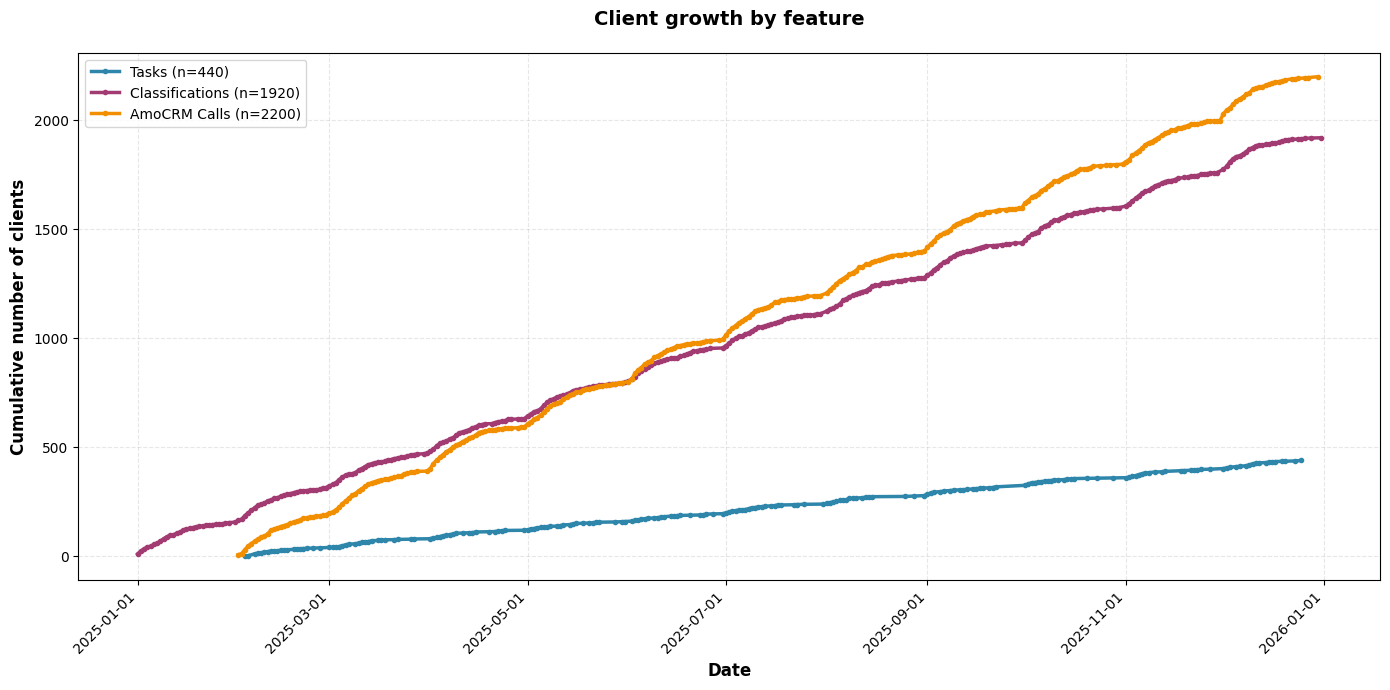


Combined cumulative client growth chart created!


In [5]:
# ============================================================================
# CLIENT GROWTH BY FEATURE — COMBINED CHART
# ============================================================================

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
colors = ["#2E86AB", "#A23B72", "#F18F01"]

for idx, (feature_name, data) in enumerate(feature_data.items()):
    growth_df = data["growth_df"]
    final_clients = growth_df.iloc[-1]["cumulative_clients"]
    ax.plot(
        growth_df["date"],
        growth_df["cumulative_clients"],
        linewidth=2.5,
        color=colors[idx],
        label=f"{feature_name} (n={final_clients:.0f})",
        marker="o",
        markersize=3,
    )

ax.set_xlabel("Date", fontsize=12, fontweight="bold")
ax.set_ylabel("Cumulative number of clients", fontsize=12, fontweight="bold")
ax.set_title("Client growth by feature", fontsize=14, fontweight="bold", pad=20)
ax.grid(True, alpha=0.3, linestyle="--")
ax.legend(loc="upper left", fontsize=10)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.tight_layout()
fig.savefig(f"{FIG_DIR}/03_client_growth_by_feature.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nCombined cumulative client growth chart created!")

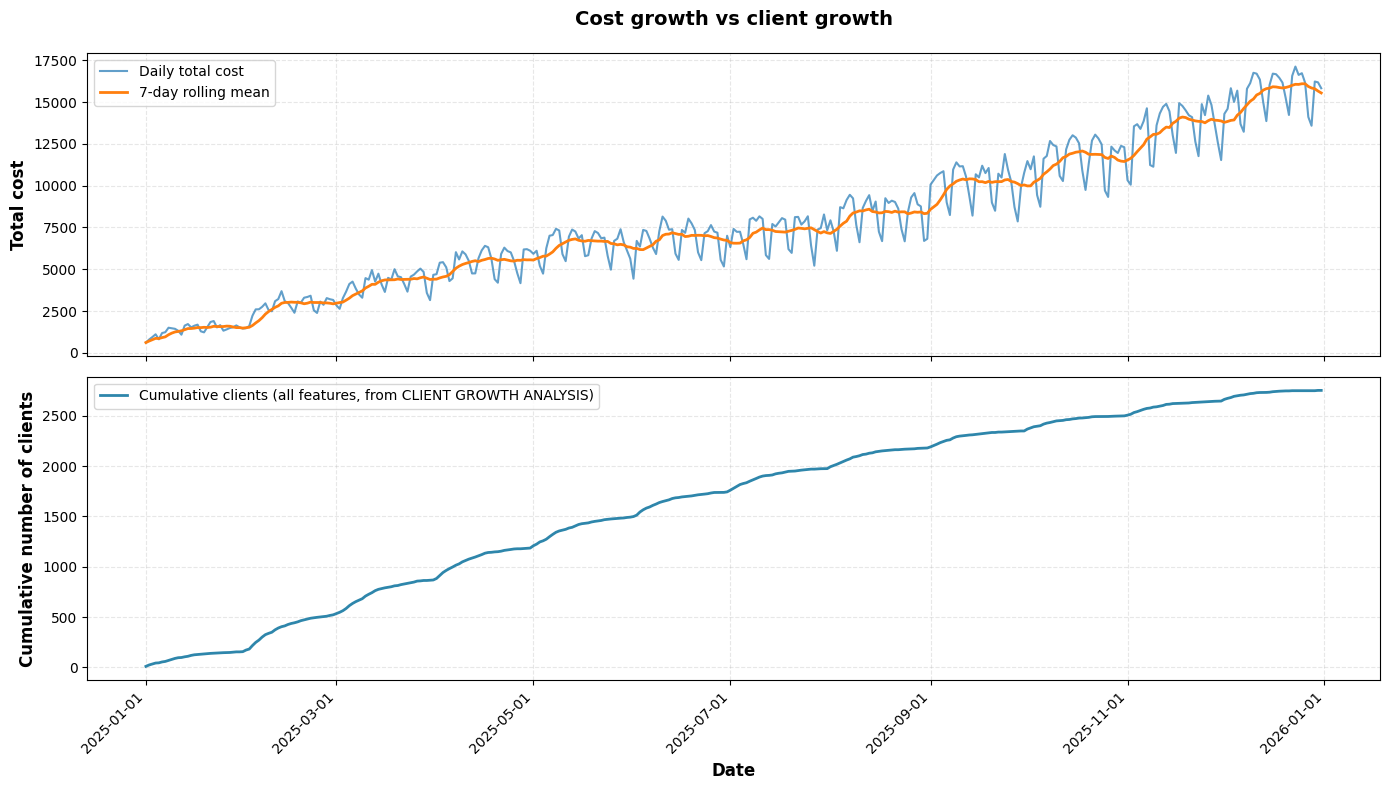

Compare the two panels: if cost and client curves rise together, cost growth is likely driven by client growth.


In [6]:
# Daily total cost and 7-day rolling mean
daily = base_ad.groupby("date", as_index=False)["total_cost"].sum()
daily["roll7"] = daily["total_cost"].rolling(7, min_periods=1).mean()

# Cumulative clients: same definition as CLIENT GROWTH ANALYSIS BY FEATURE, combined for all features
# (accounts that have used at least one of Tasks, Classifications, AmoCRM Calls)
joint_table = base.copy()
joint_table["date"] = pd.to_datetime(joint_table["date"])
combined_df = joint_table[
    (joint_table["has_tasks"] == 1)
    | (joint_table["has_classifications"] == 1)
    | (joint_table["has_amocrm_call"] == 1)
]
first_use_combined = combined_df.groupby("account_id")["date"].min()
n_per_day_combined = first_use_combined.value_counts().sort_index()
date_range = pd.date_range(base["date"].min(), base["date"].max(), freq="D")
cum_clients = n_per_day_combined.cumsum().reindex(date_range).ffill().fillna(0)

# Combined chart: cost growth vs client growth (same figure, two subplots)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top: Total cost over time (daily + 7d rolling)
ax1.plot(daily["date"], daily["total_cost"], alpha=0.7, label="Daily total cost")
ax1.plot(daily["date"], daily["roll7"], linewidth=2, label="7-day rolling mean")
ax1.set_ylabel("Total cost", fontsize=12, fontweight="bold")
ax1.set_title("Cost growth vs client growth", fontsize=14, fontweight="bold", pad=20)
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(True, alpha=0.3, linestyle="--")

# Bottom: Cumulative number of unique clients
ax2.plot(
    date_range,
    cum_clients.values,
    color="#2E86AB",
    linewidth=2,
    label="Cumulative clients (all features, from CLIENT GROWTH ANALYSIS)",
)
ax2.set_xlabel("Date", fontsize=12, fontweight="bold")
ax2.set_ylabel("Cumulative number of clients", fontsize=12, fontweight="bold")
ax2.legend(loc="upper left", fontsize=10)
ax2.grid(True, alpha=0.3, linestyle="--")
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
fig.savefig(f"{FIG_DIR}/04_cost_growth_vs_client_growth.png", dpi=150, bbox_inches="tight")
plt.show()
print(
    "Compare the two panels: if cost and client curves rise together, cost growth is likely driven by client growth."
)

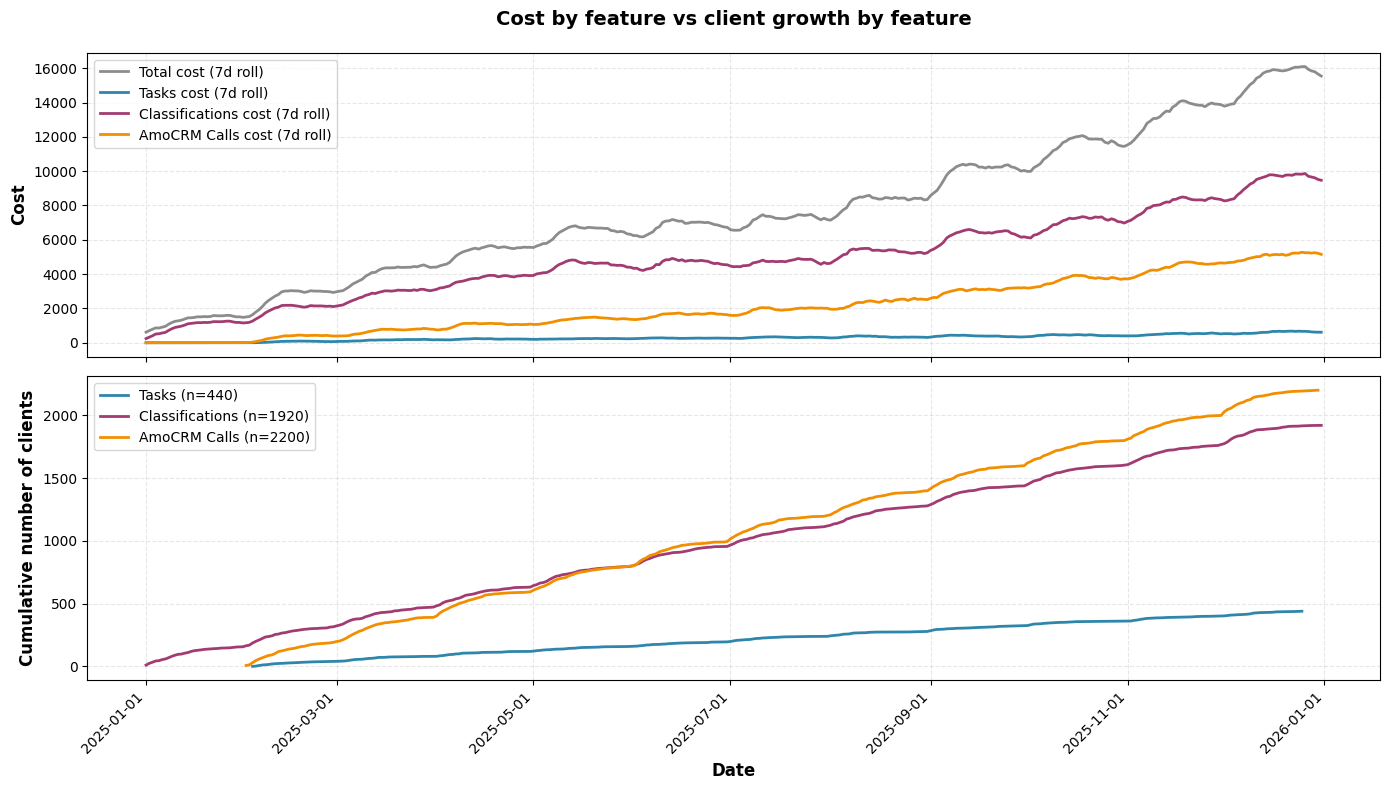

Compare cost (top) with each feature's client adoption (bottom) to see which feature drives cost.


In [7]:
# Cost growth vs client growth — split by feature (uses feature_data from CLIENT GROWTH ANALYSIS)
# Daily cost totals (overall and per feature)
daily = base_ad.groupby("date", as_index=False).agg(
    total_cost=("total_cost", "sum"),
    cost_tasks=("total_cost_tasks", "sum"),
    cost_classifications=("total_cost_classifications", "sum"),
    cost_amocrm=("cost_amocrm_call", "sum"),
)
# 7-day rolling for smoother comparison
for col in ["total_cost", "cost_tasks", "cost_classifications", "cost_amocrm"]:
    daily[f"roll7_{col}"] = daily[col].rolling(7, min_periods=1).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
colors = ["#2E86AB", "#A23B72", "#F18F01"]
feature_cost_cols = [
    ("Tasks", "cost_tasks"),
    ("Classifications", "cost_classifications"),
    ("AmoCRM Calls", "cost_amocrm"),
]

# Top: Total cost and cost by feature (7d rolling)
ax1.plot(
    daily["date"],
    daily["roll7_total_cost"],
    color="gray",
    linewidth=2,
    alpha=0.9,
    label="Total cost (7d roll)",
)
for idx, (name, col) in enumerate(feature_cost_cols):
    ax1.plot(
        daily["date"],
        daily[f"roll7_{col}"],
        color=colors[idx],
        linewidth=2,
        label=f"{name} cost (7d roll)",
    )
ax1.set_ylabel("Cost", fontsize=12, fontweight="bold")
ax1.set_title("Cost by feature vs client growth by feature", fontsize=14, fontweight="bold", pad=20)
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(True, alpha=0.3, linestyle="--")

# Bottom: Cumulative clients per feature (from feature_data)
for idx, (feature_name, data) in enumerate(feature_data.items()):
    g = data["growth_df"]
    ax2.plot(
        g["date"],
        g["cumulative_clients"],
        color=colors[idx],
        linewidth=2,
        label=f"{feature_name} (n={g['cumulative_clients'].iloc[-1]:.0f})",
    )
ax2.set_xlabel("Date", fontsize=12, fontweight="bold")
ax2.set_ylabel("Cumulative number of clients", fontsize=12, fontweight="bold")
ax2.legend(loc="upper left", fontsize=10)
ax2.grid(True, alpha=0.3, linestyle="--")
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
fig.savefig(f"{FIG_DIR}/05_cost_by_feature_vs_client_growth.png", dpi=150, bbox_inches="tight")
plt.show()
print(
    "Compare cost (top) with each feature's client adoption (bottom) to see which feature drives cost."
)

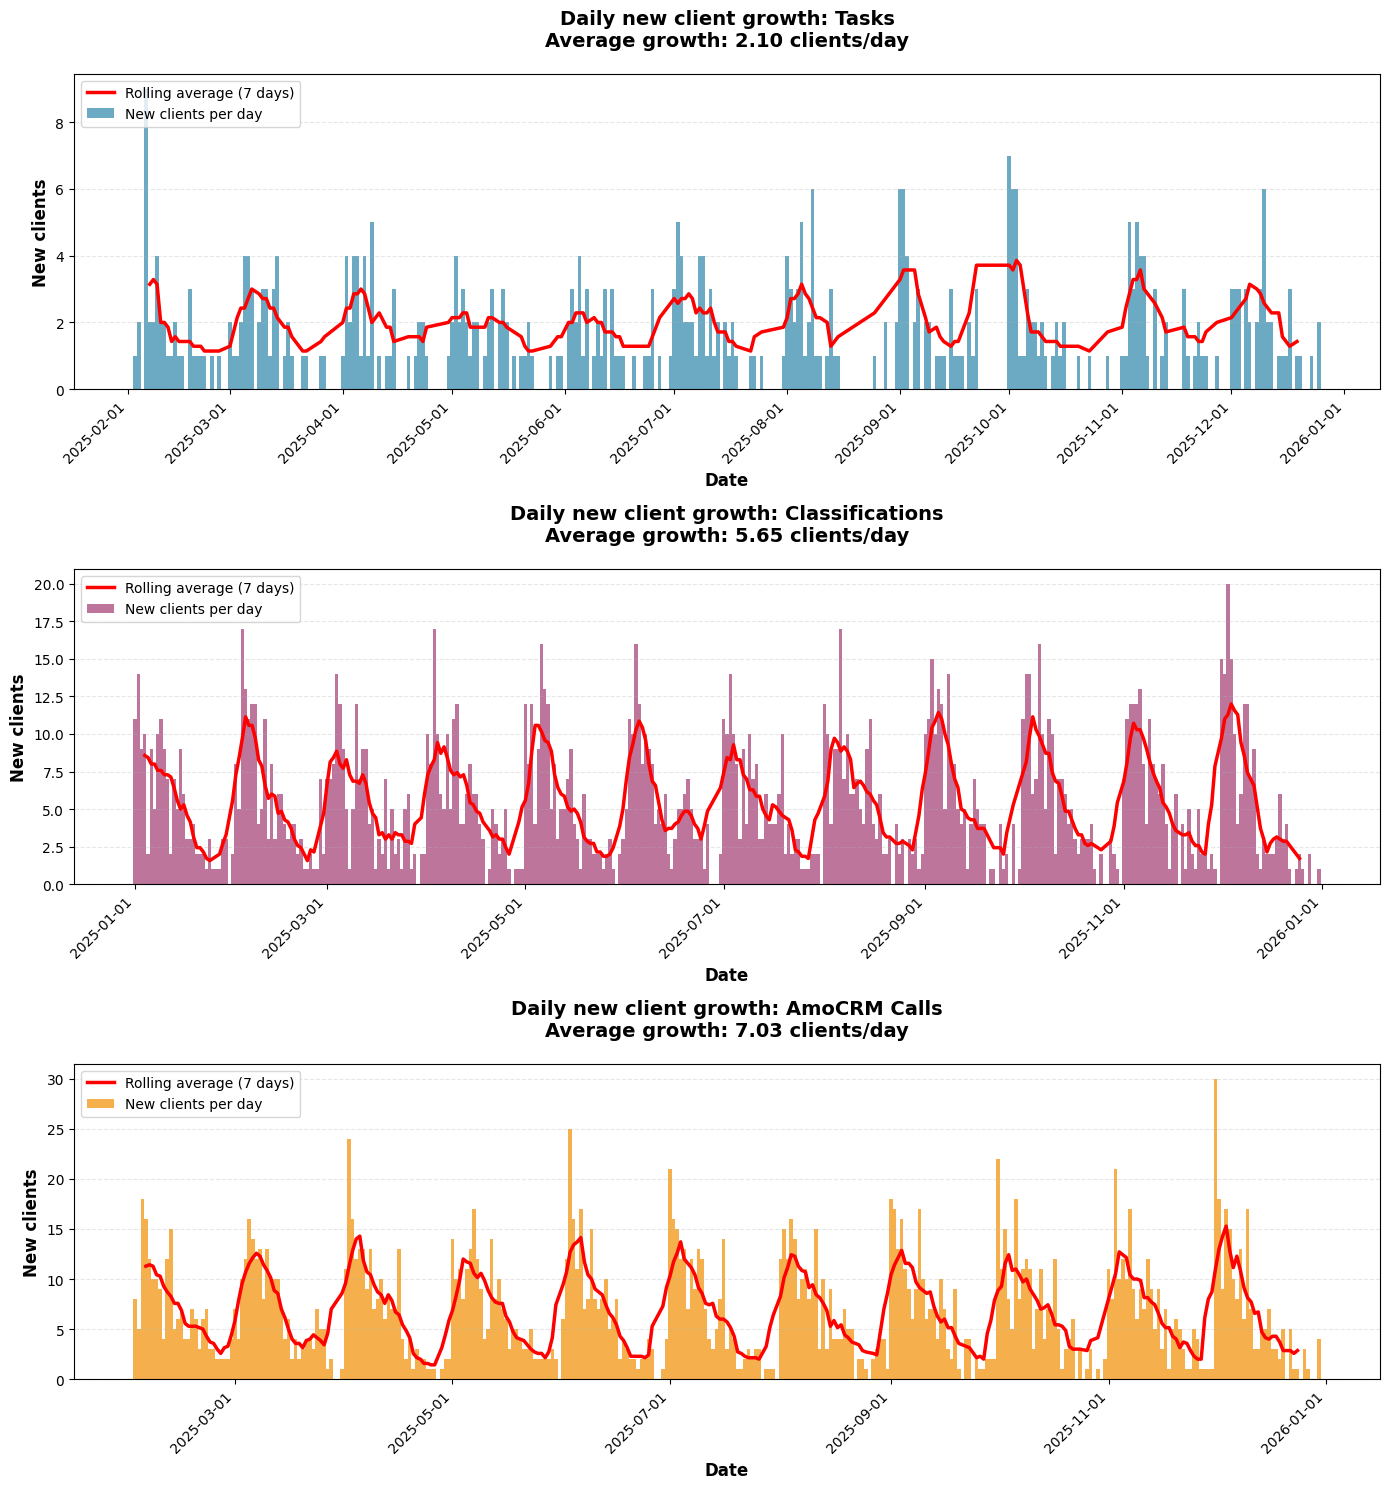


Daily growth charts created!


In [8]:
# ============================================================================
# DAILY NEW CLIENT GROWTH CHART
# ============================================================================

fig, axes = plt.subplots(len(feature_data), 1, figsize=(14, 5 * len(feature_data)))
if len(feature_data) == 1:
    axes = [axes]

for idx, (feature_name, data) in enumerate(feature_data.items()):
    ax = axes[idx]
    growth_df = data["growth_df"]

    # Daily growth chart
    ax.bar(
        growth_df["date"],
        growth_df["new_clients"],
        color=colors[idx],
        alpha=0.7,
        label="New clients per day",
        width=1,
    )

    # Add rolling average for smoothing
    window = min(7, len(growth_df) // 4)  # 7 days or 25% of data
    if window > 1:
        growth_df["ma_new_clients"] = (
            growth_df["new_clients"].rolling(window=window, center=True).mean()
        )
        ax.plot(
            growth_df["date"],
            growth_df["ma_new_clients"],
            color="red",
            linewidth=2.5,
            label=f"Rolling average ({window} days)",
        )

    ax.set_xlabel("Date", fontsize=12, fontweight="bold")
    ax.set_ylabel("New clients", fontsize=12, fontweight="bold")
    ax.set_title(
        f"Daily new client growth: {feature_name}\n"
        f"Average growth: {data['avg_daily_growth']:.2f} clients/day",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.grid(True, alpha=0.3, linestyle="--", axis="y")
    ax.legend(loc="upper left", fontsize=10)

    # Format axes
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
fig.savefig(f"{FIG_DIR}/06_daily_new_client_growth.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nDaily growth charts created!")

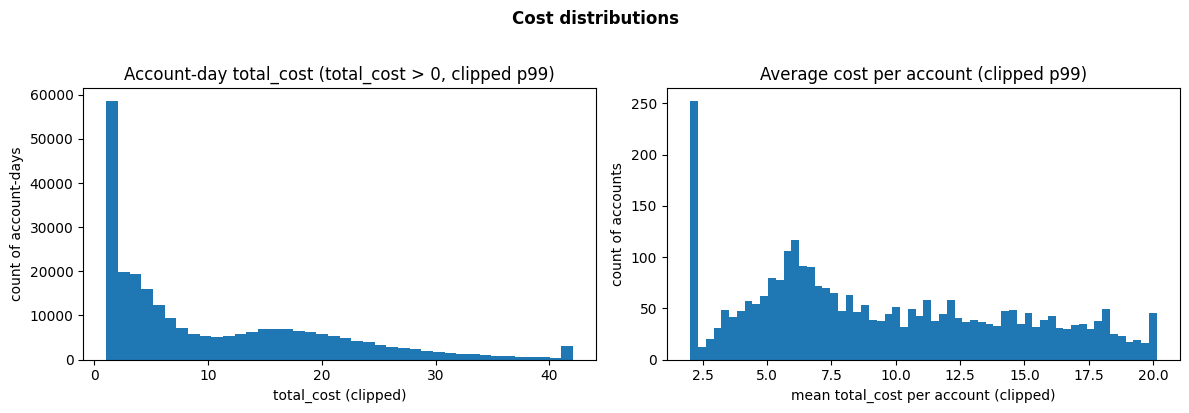

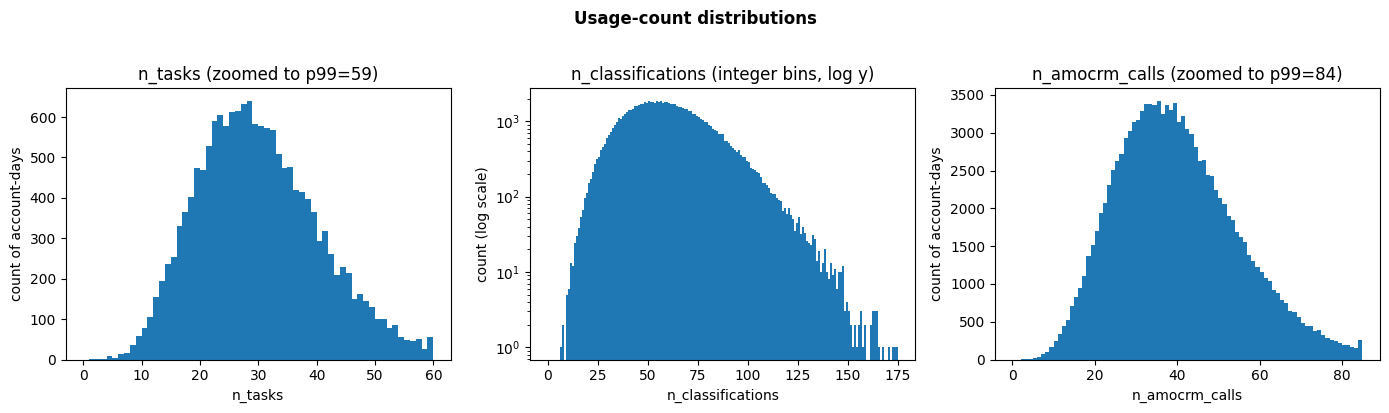

In [9]:
# ============================================================================
# DISTRIBUTIONS (always exclude rows where total_cost == 0)
# ============================================================================

# --- Figure 1: Total cost + average cost per account (2 subplots) ---
x = base_ad.loc[base_ad["total_cost"] > 0, "total_cost"]
clip = x.quantile(0.99)
base_ad_positive = base_ad[base_ad["total_cost"] > 0]
avg_cost_per_account = base_ad_positive.groupby("account_id")["total_cost"].mean()
clip_avg = avg_cost_per_account.quantile(0.99)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(x.clip(upper=clip), bins=40)
ax1.set_title("Account-day total_cost (total_cost > 0, clipped p99)")
ax1.set_xlabel("total_cost (clipped)")
ax1.set_ylabel("count of account-days")
ax2.hist(avg_cost_per_account.clip(upper=clip_avg), bins=60)
ax2.set_title("Average cost per account (clipped p99)")
ax2.set_xlabel("mean total_cost per account (clipped)")
ax2.set_ylabel("count of accounts")
plt.suptitle("Cost distributions", fontsize=12, fontweight="bold", y=1.02)
plt.tight_layout()
fig1.savefig(f"{FIG_DIR}/07_cost_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

# --- Figure 2: n_tasks, n_classifications, n_amocrm_calls (3 subplots) ---
cols = ["n_tasks", "n_classifications", "n_amocrm_calls"]
fig2, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col in zip(axes, cols, strict=True):
    v = base_ad.loc[base_ad[col] > 0, col].astype(int)

    if col == "n_classifications":
        max_v = int(v.max())
        bins = range(0, max_v + 2)
        ax.hist(v, bins=bins)
        ax.set_yscale("log")
        ax.set_title(f"{col} (integer bins, log y)")
        ax.set_ylabel("count (log scale)")
    else:
        p99 = int(v.quantile(0.99))
        bins = range(0, p99 + 2)
        ax.hist(v, bins=bins)
        ax.set_title(f"{col} (zoomed to p99={p99})")
        ax.set_ylabel("count of account-days")

    ax.set_xlabel(col)

plt.suptitle("Usage-count distributions", fontsize=12, fontweight="bold", y=1.02)
plt.tight_layout()
fig2.savefig(f"{FIG_DIR}/08_usage_count_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

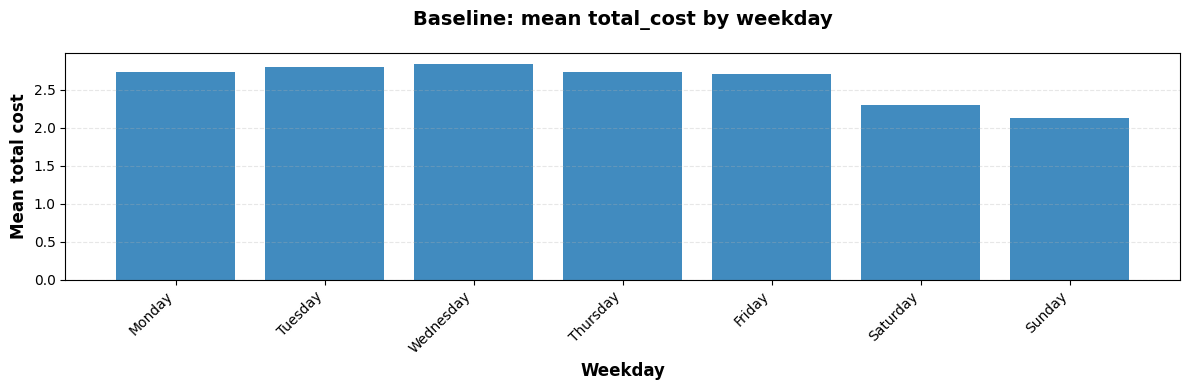

In [10]:
weekday_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
wd = base_ad.groupby("weekday", as_index=False)["total_cost"].mean()
wd["weekday"] = pd.Categorical(wd["weekday"], categories=weekday_order, ordered=True)
wd = wd.sort_values("weekday")

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(wd["weekday"], wd["total_cost"], color="C0", alpha=0.85)
ax.set_xlabel("Weekday", fontsize=12, fontweight="bold")
ax.set_ylabel("Mean total cost", fontsize=12, fontweight="bold")
ax.set_title("Baseline: mean total_cost by weekday", fontsize=14, fontweight="bold", pad=20)
ax.grid(True, alpha=0.3, linestyle="--", axis="y")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.tight_layout()
fig.savefig(f"{FIG_DIR}/09_mean_cost_by_weekday.png", dpi=150, bbox_inches="tight")
plt.show()

In [11]:
def edge_case_stats(df: pd.DataFrame, df_ad: pd.DataFrame, name: str) -> dict:
    out = {}
    out["rows"] = len(df)
    out["unique_accounts"] = int(df["account_id"].nunique())
    out["date_min"] = df["date"].min().date()
    out["date_max"] = df["date"].max().date()

    out["pct_rows_all_zero_cost"] = float((df["total_cost"] == 0).mean())
    out["pct_account_days_zero_total_cost"] = float((df_ad["total_cost"] == 0).mean())

    # heavy tail: top 1% accounts share
    acc_sum = df_ad.groupby("account_id")["total_cost"].sum().sort_values(ascending=False)
    k = max(1, int(len(acc_sum) * 0.01))
    out["top_1pct_accounts_share_of_cost"] = float(acc_sum.head(k).sum() / max(acc_sum.sum(), 1e-9))

    # chat load distribution
    out["rows_per_account_day_p95"] = float(df_ad["rows_per_account_day"].quantile(0.95))
    out["rows_per_account_day_max"] = int(df_ad["rows_per_account_day"].max())

    # component sparsity
    for col in [
        "cost_dialog",
        "total_cost_tasks",
        "total_cost_classifications",
        "cost_amocrm_call",
    ]:
        if col in df_ad.columns:
            out[f"pct_account_days_{col}_zero"] = float((df_ad[col] == 0).mean())

    # chat_type skew (row-level)
    ct = df["chat_type"].value_counts(normalize=True).head(10)
    out["top_chat_types"] = {k: float(v) for k, v in ct.items()}

    return out


base_stats = edge_case_stats(base, base_ad, "base")
anom_stats = edge_case_stats(anom, anom_ad, "anom")

print("BASE edge stats:")
for k, v in base_stats.items():
    print(f"  {k}: {v}")

print("\nANOM edge stats:")
for k, v in anom_stats.items():
    print(f"  {k}: {v}")

BASE edge stats:
  rows: 2644300
  unique_accounts: 3000
  date_min: 2025-01-01
  date_max: 2025-12-31
  pct_rows_all_zero_cost: 0.901193888741822
  pct_account_days_zero_total_cost: 0.7613753434065934
  top_1pct_accounts_share_of_cost: 0.047372999688809835
  rows_per_account_day_p95: 6.0
  rows_per_account_day_max: 31
  pct_account_days_cost_dialog_zero: 0.9451024374561608
  pct_account_days_total_cost_tasks_zero: 0.9851549713584288
  pct_account_days_total_cost_classifications_zero: 0.9175550181201777
  pct_account_days_cost_amocrm_call_zero: 0.8859433452186112
  top_chat_types: {'avito': 0.14450970010966985, 'instagram': 0.1440691298264191, 'whatsapp': 0.1438407139885792, 'viber': 0.142445259615021, 'max': 0.14239382823431532, 'vk': 0.14231327761600424, 'telegram': 0.1404280906099913}

ANOM edge stats:
  rows: 2659942
  unique_accounts: 3000
  date_min: 2025-01-01
  date_max: 2025-12-31
  pct_rows_all_zero_cost: 0.9017828208284241
  pct_account_days_zero_total_cost: 0.76139452303016